<a href="https://colab.research.google.com/github/mskbasha/Sentiment_analyis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import torch
import math
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from sklearn.metrics import f1_score
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,MultiHeadAttention,Input,LayerNormalization,Flatten

# Reading Data

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-06-16 08:39:07--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-16 08:39:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.06MB/s    in 2m 40s  

2023-06-16 08:41:48 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
from zipfile import ZipFile
with ZipFile('/content/glove.6B.zip','r') as f:
    f.extractall()

In [ ]:
with open('/content/glove.6B.200d.txt','r') as f:
    word_to_vec = {}
    for i in f.readlines():
        i = i.strip('\n').split()
        word_to_vec[i[0]] = list(map(float,i[1:]))

In [ ]:
!pip install datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import re
dataset = load_dataset("carblacac/twitter-sentiment-analysis")
data = pd.DataFrame(dataset['train'])
data.text = data.text.apply(lambda x:re.sub(r'@\w+\b','',x))

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
regex = re.compile(r'<[^>]+>')

def remove_html(string):

    return regex.sub(' ', string)

data.text = data.text.apply(lambda x:remove_html(x.lower()))
import re
regex = re.compile(r'<[^>]+>')

def remove_html(string):

    return regex.sub(' ', string)

data.text = data.text.apply(lambda x:remove_html(x.lower()))
data.text = data.text.apply(lambda x:re.sub(r'[^a-zA-Z0-9\s]', ' ', x))
data.text = data.text.apply(lambda x:' '.join(x.split()))

In [ ]:
data['lengths'] = data.text.apply(lambda x:len(x.split()))

In [ ]:
import plotly.express as px
fig = px.box(data, y="lengths")
fig.show()

<Axes: ylabel='Frequency'>

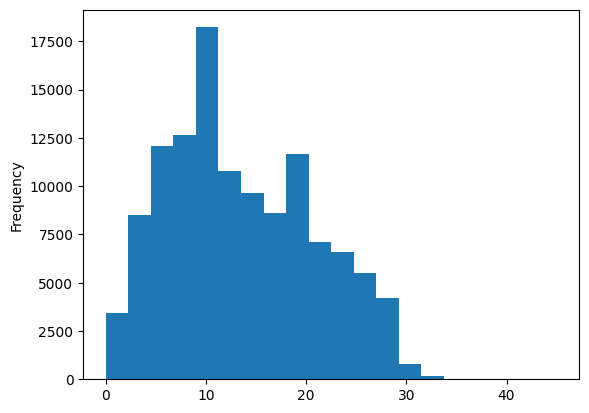

In [ ]:
data.lengths.plot.hist(bins=20)

In [ ]:
data[data.lengths<=4].shape,data.shape,data[data.lengths>25].shape

((11965, 3), (119988, 3), (7641, 3))

In [ ]:
data = data[data.lengths>4]
data = data[data.lengths<25]

In [ ]:
data.shape

(97376, 3)

In [ ]:
data.text

0         so happy that salman won btw the 14sec clip is...
1         oops i guess i m kinda out of it blonde moment...
2         decidedly undecided depends on the situation w...
3                     lol i know its so frustrating isnt it
4         didn t go much of any where life took over for...
                                ...                        
119982                      you re in chicago buy the shoes
119983              i so should be in bed but i can t sleep
119985    awe i wish i could i am here this weekend for ...
119986    is it me or is vodafone uk business support ru...
119987    http twitpic com 7jmsh my man hand with cat sc...
Name: text, Length: 97376, dtype: object

In [ ]:
word_to_vec['btw'][:5]

[-0.12618, 0.23207, 0.060967, 0.21502, 0.1475]

In [ ]:
word_to_index = {}
index_to_word = {}
index_to_vector = {}
index_to_vector[0] = torch.zeros(200)
for ind, (word,vector) in enumerate(word_to_vec.items()):
    word_to_index[word] = ind+1
    index_to_word[ind+1] = word
    index_to_vector[ind+1] = torch.tensor(vector)

In [ ]:
word_to_index['<PAD>'] = 0
index_to_word[0] = '<PAD>'
last_index = len(word_to_index)
word_to_index['<UNK>'] = last_index
index_to_word[last_index] = '<UNK>'
index_to_vector[last_index]= torch.ones(200)

In [ ]:
def func(seq):
    seq = seq.split()
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in seq]

In [ ]:
index_to_vector[word_to_index['<UNK>']]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [ ]:
func(data.text[0]),data.text[0]

([101, 1752, 13, 14842, 228, 231557, 1, 220725, 11136, 15, 225545, 8, 32265],
 'so happy that salman won btw the 14sec clip is truely a teaser')

In [ ]:
padded_sequences = pad_sequences(data.text.apply(func),
                                 maxlen=25,
                                 padding='post',
                                 value=0,
                                 truncating='post',
                                 dtype=int)

In [ ]:
padded_sequences[0]

array([   101,   1752,     13,  14842,    228, 231557,      1, 220725,
        11136,     15, 225545,      8,  32265,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0])

In [ ]:
' '.join(list(map(lambda x:index_to_word[x],padded_sequences[2])))

'decidedly undecided depends on the situation when i m out with the people i ll be in chicago with maybe <PAD> <PAD> <PAD> <PAD> <PAD>'

In [ ]:
data.feeling[2],data.text[2]

(1,
 'decidedly undecided depends on the situation when i m out with the people i ll be in chicago with maybe')

In [ ]:
x = torch.cat([torch.tensor(seq)[None,:] for seq in padded_sequences])
print(x.shape)
y = torch.tensor(data.feeling.values)

torch.Size([97376, 25])


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.10)

In [ ]:
x_train

tensor([[    42,  50748,    374,  ...,      0,      0,      0],
        [ 11084,     86,   4003,  ...,      0,      0,      0],
        [    38, 400001,     15,  ...,      0,      0,      0],
        ...,
        [  7943,    115,     42,  ...,      0,      0,      0],
        [    21,    391,     31,  ...,      0,      0,      0],
        [  6528,  14635,   2147,  ...,      0,      0,      0]])

In [ ]:
weights_matrix = torch.stack([value for value in index_to_vector.values()])

In [ ]:
# word_to_index
# index_to_word
# index_to_vector
word_to_index['<PAD>']

0

In [ ]:
weights_matrix[400001]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [ ]:
        num_embeddings, embedding_dim = weights_matrix.size()
        self.emb = torch.nn.Embedding(num_embeddings, embedding_dim)
        self.emb.load_state_dict({'weight': weights_matrix})
        self.emb.weight.requires_grad = False

In [ ]:
emb_layer(x_train[:1])

tensor([[[ 0.2680,  0.3603, -0.3320,  ...,  0.1777,  0.2236,  0.0142],
         [-0.0258, -0.3194, -0.0279,  ...,  0.4480,  0.2473, -0.2543],
         [ 0.2901,  0.8230,  0.3916,  ...,  0.0404,  0.0774, -0.0268],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self,no_heads,seq_len,Embedding_dim):
        super().__init__()
        self.mha = torch.nn.MultiheadAttention(Embedding_dim,no_heads,batch_first=True,dropout = 0.1)
        self.FF = torch.nn.Sequential(
            torch.nn.Linear(Embedding_dim,4*Embedding_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(4*Embedding_dim,Embedding_dim),
            torch.nn.Dropout(0.1)
        )
        self.ln1 = torch.nn.LayerNorm(Embedding_dim)
        self.ln2 = torch.nn.LayerNorm(Embedding_dim)
    def __call__(self,x,key_padding_mask):
        # mask = torch.triu(torch.ones(x.shape[-2], x.shape[-2],dtype =bool), diagonal=1)
        x1 = self.ln1(x)
        x = x+self.mha(x1,x1,x1,key_padding_mask=key_padding_mask)[0]
        x = x+self.FF(self.ln2(x))
        return x
class Decoder(torch.nn.Module):
    def __init__(self,no_blocks,no_heads,seq_len,Embedding_dim,vocab_size,weights_matrix):
        super().__init__()
        self.seq_length = seq_len
        self.blocks = torch.nn.ModuleList([EncoderLayer(no_heads,seq_len,Embedding_dim) for _ in range(no_blocks)])
        # self.pool = torch.nn.MaxPool1d(vocab_size)
        self.out = torch.nn.Linear(seq_len,2)
        self.flat = torch.nn.Linear(Embedding_dim,1)
        num_embeddings, embedding_dim = weights_matrix.size()
        self.emb = torch.nn.Embedding(num_embeddings, embedding_dim)
        self.emb.load_state_dict({'weight': weights_matrix})
        self.emb.weight.requires_grad = False
        self.PE = torch.nn.Embedding(seq_len,Embedding_dim)
        self.ln2 = torch.nn.LayerNorm(Embedding_dim)
        self.relu = torch.nn.ReLU()
        self.drops = torch.nn.Dropout(0.1)
    def __call__(self,x):
        x1 = self.emb(x)
        mask = (x==0)
        mask = mask.to(device)
        x = x1+self.PE(torch.arange(self.seq_length,device = torch.device(device)))
        for block in self.blocks:
            x = block(x,mask)
        x = self.ln2(x)
        x = self.drops(x)
        x = self.relu(x)
        x = self.flat(x).squeeze()
        return self.out(x).squeeze()
embedding_dim = 80
model = Decoder(25,4,25,200,25,weights_matrix).cuda()
# Decoder(10,5,25,200,25,weights_matrix).cuda()(x_train[:1].cuda())

In [ ]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
count_parameters(model)

+-------------------------------+------------+
|            Modules            | Parameters |
+-------------------------------+------------+
|  blocks.0.mha.in_proj_weight  |   120000   |
|   blocks.0.mha.in_proj_bias   |    600     |
|  blocks.0.mha.out_proj.weight |   40000    |
|   blocks.0.mha.out_proj.bias  |    200     |
|      blocks.0.FF.0.weight     |   160000   |
|       blocks.0.FF.0.bias      |    800     |
|      blocks.0.FF.2.weight     |   160000   |
|       blocks.0.FF.2.bias      |    200     |
|      blocks.0.ln1.weight      |    200     |
|       blocks.0.ln1.bias       |    200     |
|      blocks.0.ln2.weight      |    200     |
|       blocks.0.ln2.bias       |    200     |
|  blocks.1.mha.in_proj_weight  |   120000   |
|   blocks.1.mha.in_proj_bias   |    600     |
|  blocks.1.mha.out_proj.weight |   40000    |
|   blocks.1.mha.out_proj.bias  |    200     |
|      blocks.1.FF.0.weight     |   160000   |
|       blocks.1.FF.0.bias      |    800     |
|      blocks

12070653

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
train = TensorDataset(x_train, y_train)
test =  TensorDataset(x_test, y_test)
batch_size = 32
train_dataset, test_dataset = DataLoader(train,batch_size=batch_size, shuffle=True),DataLoader(test,batch_size=batch_size, shuffle=True)

In [ ]:
model = model.cuda()

In [ ]:
x_train.shape

torch.Size([87638, 25])

In [ ]:
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import math
class progressbar:
    def __init__(self,timegap,length=40,char1='-',char2='>'):
        self.start_time = time.time()
        self.timegap=timegap
        self.time_ellapsed=0
        self.length = length
        self.char1 = char1
        self.char2 = char2
        self.data=[]
        self.extraword=''
        self.past = 0
        self.tim1 = 0
        self.past_error = 0
    def print(self,current,max,string='',clear=True,graph=False,error=0,graph_length=10,smoothing=0.2,another=False):
        assert smoothing<1
        progress=round(self.length*current/max)
        if progress == 0:
            self.past_error = error
        if time.time()-self.start_time>self.timegap:
            self.start_time = time.time()
            self.time_ellapsed+=self.timegap
            self.extraword+='\n Time taken ='+str(self.time_ellapsed)+'sec'
            if clear:
                clear_output(wait=True)
            if progress!=self.past:
                self.tim1 = round((self.length-progress)/(progress-self.past+0.1)*self.timegap,2)
            print('['+self.char1*int(progress)+self.char2+' '*(self.length-progress)+']',
                    '\n',
                    string,
                    f"\ntime {self.tim1}s",
                    f"\ntime_spent {self.time_ellapsed}s",
                    flush=True)
            self.past = progress
            if graph:
                if len(self.data)>graph_length:
                    self.data.pop(0)
                    # print(self.data,graph_length,len(self.data))
                error = smoothing*error+(1-smoothing)*self.past_error
                self.past_error = error
                self.data.append([self.time_ellapsed,error])
                plt.plot([x[0] for x in self.data],[x[1] for x in self.data])
                if not another:
                    plt.show()

In [ ]:
for i ,j in test_dataset:
    print(i.shape,j.shape)
    break

torch.Size([32, 25]) torch.Size([32])


In [ ]:
def predict(dataset,batch_size,model):
    y_pred = []
    y_true = []
    pb = progressbar(1,40,'#',' ')
    with torch.no_grad():
        for ind,(inputs,labels) in enumerate(dataset):
            pb.print(ind,len(dataset))
            inputs = inputs.cuda()
            y_pred.append(torch.argmax(model(inputs),axis=-1))
            y_true.append(labels)
        y_pred,y_true = torch.cat(y_pred),torch.cat(y_true)
        return f1_score(y_true.cpu(),y_pred.cpu(),average='macro')
predict(test_dataset,32,model)

[#####################################    ] 
  
time 0.25s 
time_spent 3s


0.4149942227595744

[##                                       ] 
 
 0.64895 for 0 epoch f1score = 0,0 
time 34.55s 
time_spent 13s


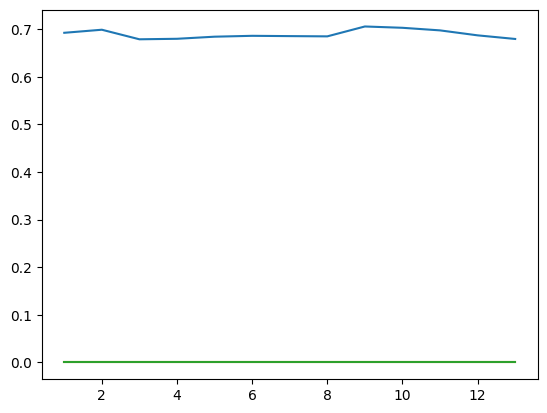

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
pb1 = progressbar(1,40,'#',' ')
pb2 = progressbar(1,40,'#',' ')
pb3 = progressbar(1,40,'#',' ')
test_score = 0
train_score = 0
train_max = 0
test_max = 0
for epoch in range(100):
    for i,(inputs,labels) in enumerate(train_dataset):
        optimizer.zero_grad()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        pb1.print(i,len(train_dataset),
                  f"\n {round(loss.item(),5)} for {epoch} epoch f1score = {round(test_score,2)},{round(train_score,2)}",
                 graph=True,
                  error=loss.item(),
                  graph_length=200,
                  another = True)
        pb2.print(i,len(train_dataset),
                  f"\n {round(loss.item(),5)} for {epoch} epoch f1score = {round(test_score,2)},{round(train_score,2)}",
                 graph=True,
                  error=test_score,
                  graph_length=200,
                  another = True)
        pb3.print(i,len(train_dataset),
                  f"\n {round(loss.item(),5)} for {epoch} epoch f1score = {round(test_score,2)},{round(train_score,2)}",
                 graph=True,
                  error=train_score,
                  graph_length=200,
                  another = False)
    test_score = predict(test_dataset,32,model)
    train_score = predict(train_dataset,32,model)
    train_max = max(train_max,train_score)
    test_max = max(test_max,test_score)


In [ ]:
outputs

tensor([[-0.1651,  0.3264],
        [ 0.1143, -0.1576],
        [ 0.2405, -0.3128],
        [ 0.9251, -0.8897],
        [-0.3419,  0.3953],
        [ 0.7665, -0.8509],
        [-0.3636,  0.7185],
        [ 1.2371, -1.3643],
        [ 0.2463, -0.4717],
        [ 0.6272, -0.7681],
        [-0.2137,  0.5109],
        [ 0.8147, -1.2490],
        [-1.4558,  1.9059],
        [ 0.4466, -0.5666],
        [ 1.1203, -0.4615],
        [-0.4719,  0.5770],
        [-1.5568,  2.4669],
        [ 0.0281, -0.0224],
        [-0.1983,  0.4836],
        [ 1.0985, -0.9627],
        [ 0.3318, -0.1571],
        [ 0.8018, -0.9954],
        [ 0.3915, -0.4358],
        [-0.5689,  1.4880],
        [-0.4888,  0.6434],
        [ 0.0878,  0.1038],
        [-0.2042,  0.4649],
        [ 0.0054,  0.1561],
        [ 0.8814, -1.2539],
        [-0.6967,  1.0891],
        [-0.8947,  1.3599],
        [-0.9760,  1.3594]], device='cuda:0', grad_fn=<SqueezeBackward0>)